In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# This project requires Python 3.10 or above:
import sys
assert sys.version_info >= (3, 10)

# We also need PyTorch ≥ 2.6.0:
from packaging.version import Version
import torch
assert Version(torch.__version__) >= Version("2.6.0")

from torch.utils.data import DataLoader
import torch.nn as nn
import torchmetrics
import matplotlib.pyplot as plt

In [5]:
from ldm_ludo import diff_model as dm
from ldm_ludo import data
from ldm_ludo import plots
from ldm_ludo import utils
from ldm_ludo import training

In [6]:
# Prefer and hw accelerator
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [7]:
# Set seed for reproducibility
torch.manual_seed(42)

# Variance schedule: get alphas and betas
T = int(1000)
embed_dim = 64 # TODO change this for time embedding
alphas, betas, alpha_bars = dm.variance_schedule(T)

In [9]:
# Load dataset, split it, and load it into DataLoaders
train_data, valid_data, test_data = data.loadDataset("mnist")
train_set = data.DiffusionDataset(train_data, T, alpha_bars)  # wrap dataset
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_set = data.DiffusionDataset(valid_data, T, alpha_bars)
valid_loader = DataLoader(valid_set, batch_size=32)

In [10]:
diffusion_model = dm.DiffusionModel(T).to(device)

In [28]:
# let's train the model
torch.manual_seed(42)
huber = nn.HuberLoss()
n_epochs = 1
optimizer = torch.optim.NAdam(diffusion_model.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = training.train(diffusion_model, optimizer, huber, rmse, train_loader,
                valid_loader, device=device, n_epochs=n_epochs)

Batch 25/1688, loss=0.0362, train_metric=0.277

KeyboardInterrupt: 

In [8]:
# save model's trained weights
utils.save_model(diffusion_model)

In [11]:
# load model's weights
utils.load_last_model(diffusion_model)

In [27]:
# Generate images
X_gen = dm.generate_ddpm(diffusion_model, T, alphas=alphas, alpha_bars=alpha_bars, betas=betas, device=device)  # generated images
utils.plot_multiple_images(X_gen, 8)

t = 951  

KeyboardInterrupt: 

t = 19  

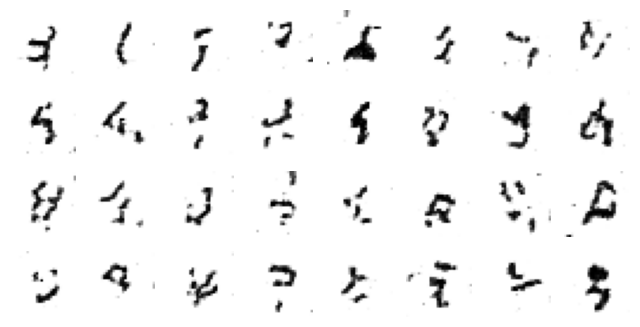

In [26]:
# use DDIM sampling
X_gen_ddim = dm.generate_ddim(diffusion_model, T, alphas=alphas, alpha_bars=alpha_bars, betas=betas, device=device, num_steps=50)
utils.plot_multiple_images(X_gen_ddim, 8)
plt.show()